# CNN based on Nvidias Model

This Convulutional Neuronal Network is based on Nvidias Architecture
https://devblogs.nvidia.com/deep-learning-self-driving-cars/

## import libraries

In [116]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os
import fnmatch
import cv2

## loading training data

Goes into the training data directory and extracts every .jpg image and the coressponding label from the file name

In [122]:
data_dir = '../training_data/black_dot'
file_list = os.listdir(data_dir)
images = []
labels = []
pattern = "*.jpg"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_path = os.path.join(data_dir,filename)
        images.append(mpimg.imread(image_path))
        steering = int(filename[-13:-9]) 
        labels.append(steering)

print("Max Label Value: ", max(labels))
print("Min Label Value: ", min(labels))

Max Label Value:  1958
Min Label Value:  1007


## Preprocessing training images

Nvidias Model calls for images in 200 x 66 Pixel resolution and in the YUV color space. The images also need to be normalized.

In [79]:
def preprocess(image):
    height, _, _ = image.shape
    qheight = int(height/4)
    hheight = int(height/2)
    image = image[qheight:qheight+hheight,:,:] # cropping so only the middle half is visible
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    return image

In [123]:
processed_images = []
for image in images:
    processed_images.append(preprocess(image))
    
processed_images = np.array(processed_images)
labels = np.array(labels)

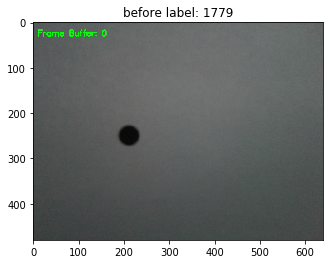

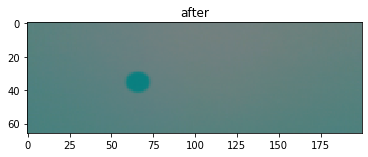

In [124]:
import random
randindex = random.randint(0,len(images))
plt.title("before label: %04d" % (labels[randindex]))
plt.imshow(images[randindex])
plt.show()


plt.title("after")
plt.imshow(processed_images[randindex]) # just to test the cropping of image.
plt.show()

## split data into train and test set

In [125]:
data_train, data_valid, labels_train, labels_valid = train_test_split(processed_images, labels, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(data_train), len(data_valid)))

Training data: 3656
Validation data: 914


## defining cnn

In [113]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # skipping normalization layer since the data is already normalized (proprocessing)
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: steering angle as PWM value (~1000-2000) -> ~1500 straight
    model.add(Dense(1)) 
    
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer) # mean squared error because it is a regression problem
    
    return model

In [117]:
model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

## training process

In [126]:
# Hyperparamter
my_batch_size = 128
my_num_classes = 10
my_epochs = 10

history = model.fit(data_train, labels_train,
                   batch_size=my_batch_size,
                   epochs=my_epochs,
                   verbose=1,
                   validation_data=(data_valid, labels_valid))

model.save('lane_navigation.h5')

Train on 10 samples, validate on 914 samples
10/10 [==============================] - 4s 399ms/sample - loss: 2205175.5000 - val_loss: 2170610.6392


## Validation

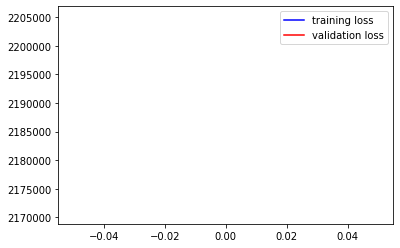

In [130]:
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [133]:
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

def summarize_prediction(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    
def predict_and_summarize(X, Y):
    model = load_model('lane_navigation.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred
  
y_pred = predict_and_summarize(data_valid, labels_valid)

mse       = 2.2e+06
r_squared = -3217.32%
